In [1]:
#import torch
import os, sys, re, time
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

170111


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
ls 

20230513-Segmentation.ipynb        20230818-Segmentation.ipynb
20230623-Segmentation-Copy1.ipynb  20231224-Segmentation.ipynb
20230623-Segmentation.ipynb


In [6]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20230824-Merscope01'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation
/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/watershed


In [7]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [8]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_MF5.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215
-- 13 folders, 503 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Analysis/color_usage_MF5.csv


In [9]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '637', 'hyb': 'H12M13'} 477


# Run segmentation

In [19]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d
from merlin.analysis.segment import CellPoseSegment

In [11]:
from importlib import reload

In [12]:
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [22]:
for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    #_ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls.ref_correction_channel = '637'
    #_cls._corr_illumination()
    _cls._calculate_drift(_ref_im, )
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    
    _dapi_im = getattr(_ref_cls, f"im_{dapi_info['channel']}")
    _polyt_im = getattr(_cls, f"im_{polyt_info['channel']}")
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=50, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    
    #break

Segmentation label file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_0.npy already exists, skip
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_001.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_001.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_001.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_001_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.163s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_001.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/

- Loaded images for channels:['477', '405'] in 2.937s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_005.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_005_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.644s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -47.66 179.33] in 0.686s.
-- drift 1: [ 4.0000e-02 -4.5770e+01  1.4155e+02] in 0.606s.
-- drift 2: [ 3.0000e-02 -4.4650e+01  1.4121e+02] in 0.617s.
-- drift 3: [0.46 0.02 0.01] in 0.613s.
-- drift 4: [  0.99 170.15 118.31] in 0.616s.
-- drift 5: [-2.000e-02  2.504e+01 -4.824e+01] in 0.605s.
-- drift 6: [  -1.01 -235.24 -132.65] in 0.604s.
-- drift 7: [ 2.0000e-02 -4.5390e+01  1.4178e+02] in 0.615s.
-- return a sub-optima

-- drift 1: [ 1.0000e-02 -4.7030e+01  1.4003e+02] in 0.595s.
-- drift 2: [  -5.97 -108.05   80.93] in 0.595s.
-- drift 3: [-0.24  0.01  0.02] in 0.602s.
-- drift 4: [  0.   -46.48 140.46] in 0.602s.
-- drift 5: [ 1.0000e-02 -4.6720e+01  1.4069e+02] in 0.601s.
-- drift 6: [ 2.0000e-02 -4.6920e+01  1.4065e+02] in 0.603s.
-- drift 7: [ 1.000e-02 -4.654e+01  1.403e+02] in 0.595s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.400s.
- Finished warp correction in 10.400s.
- apply microscope corrections
- run Cellpose segmentation in 42.222s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_9.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_010.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv

- Loaded images for channels:['477', '405'] in 2.921s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_014.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_014_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 2.345s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.0000e-02 -4.6840e+01  1.4342e+02] in 0.744s.
-- drift 1: [ 2.0000e-02 -4.6500e+01  1.4404e+02] in 0.655s.
-- drift 2: [ 1.0000e-02 -4.5710e+01  1.4339e+02] in 0.579s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.413s.
- Finished warp correction in 10.413s.
- apply microscope cor

- Loaded images for channels:['477', '405'] in 2.155s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_019.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_019_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.905s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.0000e-02 -4.7290e+01  1.4271e+02] in 0.664s.
-- drift 1: [ 3.0000e-02 -4.6890e+01  1.4328e+02] in 0.579s.
-- drift 2: [ 1.0000e-02 -4.6130e+01  1.4277e+02] in 0.592s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.489s.
- Finished warp correction in 10.489s.
- apply microscope cor

- run Cellpose segmentation in 37.529s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_23.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_024.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_024.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_024.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_024_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.162s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_024.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-s

- Loaded images for channels:['637', '477'] in 2.288s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.0000e-02 -4.7340e+01  1.4231e+02] in 0.705s.
-- drift 1: [ 1.000e-02 -4.708e+01  1.431e+02] in 0.626s.
-- drift 2: [-1.0000e-02 -4.6290e+01  1.4238e+02] in 0.591s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.427s.
- Finished warp correction in 10.427s.
- apply microscope corrections
- run Cellpose segmentation in 48.926s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_28.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_029.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zsca

- Loaded images for channels:['477', '405'] in 2.200s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_033.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_033_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 2.855s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.0000e-02 -4.6430e+01  1.4317e+02] in 0.722s.
-- drift 1: [ 1.0000e-02 -4.6040e+01  1.4391e+02] in 0.587s.
-- drift 2: [  0.   -45.3  143.29] in 0.601s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 11.317s.
- Finished warp correction in 11.317s.
- apply microscope corrections
- run 

- Loaded images for channels:['477', '405'] in 2.210s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_038.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_038_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.824s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.0000e-02 -4.7180e+01  1.4065e+02] in 0.719s.
-- drift 1: [ 2.0000e-02 -4.6660e+01  1.4157e+02] in 0.592s.
-- drift 2: [  0.   -45.89 140.88] in 0.592s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.436s.
- Finished warp correction in 10.436s.
- apply microscope corrections
- run 

-- corrected warp for channel 637 in 10.413s.
- Finished warp correction in 10.413s.
- apply microscope corrections
- run Cellpose segmentation in 49.334s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_42.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_043.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_043.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_043.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_043_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.556s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain

-- drift 0: [ 1.0000e-02 -4.6790e+01  1.4325e+02] in 0.647s.
-- drift 1: [  0.   -46.66 143.98] in 0.619s.
-- drift 2: [-1.0000e-02 -4.5940e+01  1.4315e+02] in 0.615s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.451s.
- Finished warp correction in 10.451s.
- apply microscope corrections
- run Cellpose segmentation in 51.933s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_47.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_048.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_048.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_048.dax
- New save file: /lab/weissman_imagin

- Loaded images for channels:['637', '477'] in 1.433s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -48.03 141.14] in 0.678s.
-- drift 1: [ 1.0000e-02 -4.7540e+01  1.4199e+02] in 0.594s.
-- drift 2: [-1.0000e-02 -4.6840e+01  1.4124e+02] in 0.588s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.432s.
- Finished warp correction in 10.433s.
- apply microscope corrections
- run Cellpose segmentation in 50.070s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_52.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_053.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_053.dax
In

- Loaded images for channels:['477', '405'] in 2.251s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_057.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_057_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.569s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.0000e-02 -4.8130e+01  1.4133e+02] in 0.681s.
-- drift 1: [   3.06  139.36 -212.82] in 0.581s.
-- drift 2: [-1.0000e-02 -4.7010e+01  1.4136e+02] in 0.583s.
-- drift 3: [-5.6  -0.01  0.01] in 0.573s.
-- drift 4: [  0.   -47.51 141.42] in 0.586s.
-- drift 5: [ 1.0000e-02 -4.7470e+01  1.4247e+02] in 0.582s.
-- drift 6: [  -3.95 -189.11  187.81] in 0.581s.
-- drift 7: [ 2.0000e-02 -4.7340e+01  1.4229e+02] in 0.576s.
-- return a s

reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_062.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_062.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_062.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_062_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 3.578s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_062.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_062_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637'

-- drift 2: [  0.   -47.11 141.36] in 0.568s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.707s.
- Finished warp correction in 10.708s.
- apply microscope corrections
- run Cellpose segmentation in 51.487s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_66.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_067.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_067.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_067.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_067_processed.hdf5
-- all used channels: ['748', '637',

- Loaded images for channels:['637', '477'] in 1.556s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.0000e-02 -4.8460e+01  1.4039e+02] in 0.651s.
-- drift 1: [ 2.0000e-02 -4.8010e+01  1.4124e+02] in 0.589s.
-- drift 2: [ 2.0000e-02 -4.7330e+01  1.4042e+02] in 0.597s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.390s.
- Finished warp correction in 10.390s.
- apply microscope corrections
- run Cellpose segmentation in 55.056s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_71.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_072.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_z

- Loaded images for channels:['477', '405'] in 2.053s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_076.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_076_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 2.155s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ -0.98 -75.45 -18.05] in 0.696s.
-- drift 1: [ 2.0000e-02 -4.7200e+01  1.4262e+02] in 0.605s.
-- drift 2: [ 1.0000e-02 -4.6280e+01  1.4191e+02] in 0.609s.
-- drift 3: [ 5.000e-02 -4.669e+01  1.426e+02] in 0.602s.
-- drift 4: [ 1.97  7.77 79.68] in 0.651s.
-- drift 5: [ 1.0000e-02 -4.6940e+01  1.4283e+02] in 0.607s.
-- drift 6: [ 1.0000e-02 -4.7060e+01  1.4302e+02] in 0.605s.
-- drift 7: [  0.   -46.86 142.75] in 0.610s.
-- retu

reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_081.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_081.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_081.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_081_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.002s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_081.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_081_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637'

-- drift 0: [ 1.0000e-02 -4.7190e+01  1.4286e+02] in 0.582s.
-- drift 1: [ 2.0000e-02 -4.6920e+01  1.4365e+02] in 0.550s.
-- drift 2: [-1.0000e-02 -4.6050e+01  1.4291e+02] in 0.546s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.424s.
- Finished warp correction in 10.425s.
- apply microscope corrections
- run Cellpose segmentation in 48.868s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_85.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_086.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_086.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_086.dax
- New save file: /lab/

- Loaded images for channels:['637', '477'] in 2.009s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.0000e-02 -4.7870e+01  1.4144e+02] in 0.571s.
-- drift 1: [ 2.000e-02 -4.758e+01  1.422e+02] in 0.549s.
-- drift 2: [ 1.0000e-02 -4.6850e+01  1.4154e+02] in 0.553s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 11.075s.
- Finished warp correction in 11.075s.
- apply microscope corrections
- run Cellpose segmentation in 50.279s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_90.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_091.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zsca

- Loaded images for channels:['477', '405'] in 2.204s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_095.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_095_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.532s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.0000e-02 -4.7190e+01  1.4241e+02] in 0.684s.
-- drift 1: [ 2.0000e-02 -4.7050e+01  1.4312e+02] in 0.583s.
-- drift 2: [  0.   -46.16 142.35] in 0.590s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.400s.
- Finished warp correction in 10.400s.
- apply microscope corrections
- run 

- Loaded images for channels:['477', '405'] in 2.580s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_100.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_100_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.682s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -47.98 140.81] in 0.672s.
-- drift 1: [  0.   -47.56 141.61] in 0.594s.
-- drift 2: [  0.   -46.74 140.94] in 0.599s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.319s.
- Finished warp correction in 10.319s.
- apply microscope corrections
- run Cellpose segmentation in 50.10

- Loaded images for channels:['477', '405'] in 2.189s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_105.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_105_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.797s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -47.92 141.42] in 0.697s.
-- drift 1: [  0.   -47.71 142.05] in 0.614s.
-- drift 2: [-1.0000e-02 -4.6870e+01  1.4152e+02] in 0.610s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.443s.
- Finished warp correction in 10.443s.
- apply microscope corrections
- run Cellpose segmen

- Loaded images for channels:['477', '405'] in 2.661s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_110.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_110_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.656s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 5.0000e-02 -4.8250e+01  1.4131e+02] in 0.691s.
-- drift 1: [  -0.98 -106.57   79.81] in 0.615s.
-- drift 2: [-1.0000e-02 -4.7840e+01  1.4054e+02] in 0.598s.
-- drift 3: [ 1.0000e-02 -4.7710e+01  1.4156e+02] in 0.620s.
-- drift 4: [-1.0000e-02 -4.8030e+01  1.4092e+02] in 0.593s.
-- drift 5: [  4.01 147.55 192.13] in 0.591s.
-- drift 6: [ 2.0000e-02 -4.8180e+01  1.4207e+02] in 0.594s.
-- drift 7: [  -3.95  120.2  -131.83] in 0.6

-- corrected warp for channel 637 in 10.561s.
- Finished warp correction in 10.561s.
- apply microscope corrections
- run Cellpose segmentation in 52.018s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_114.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_115.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_115.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_115.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_115_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 1.908s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrai

- Loaded images for channels:['637', '477'] in 1.830s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 3.0000e-02 -4.5980e+01  1.4357e+02] in 0.609s.
-- drift 1: [ 3.0000e-02 -4.5620e+01  1.4443e+02] in 0.573s.
-- drift 2: [ 2.0000e-02 -4.4840e+01  1.4378e+02] in 0.575s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.438s.
- Finished warp correction in 10.439s.
- apply microscope corrections
- run Cellpose segmentation in 48.561s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_119.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_120.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_

- Loaded images for channels:['477', '405'] in 2.331s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_124.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_124_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 2.156s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 2.0000e-02 -4.6110e+01  1.4368e+02] in 0.677s.
-- drift 1: [ 1.0000e-02 -4.5740e+01  1.4427e+02] in 0.594s.
-- drift 2: [ 2.0000e-02 -4.4900e+01  1.4368e+02] in 0.593s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.331s.
- Finished warp correction in 10.331s.
- apply microscope cor

- Loaded images for channels:['477', '405'] in 2.342s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_129.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_129_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.806s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 3.0000e-02 -4.6520e+01  1.4269e+02] in 0.693s.
-- drift 1: [ 2.0000e-02 -4.6180e+01  1.4353e+02] in 0.594s.
-- drift 2: [ 1.0000e-02 -4.5340e+01  1.4276e+02] in 0.602s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.316s.
- Finished warp correction in 10.316s.
- apply microscope cor

- Loaded images for channels:['477', '405'] in 2.337s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_134.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_134_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.918s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -4.601e+01  1.437e+02] in 0.722s.
-- drift 1: [ 2.0000e-02 -4.5560e+01  1.4457e+02] in 0.583s.
-- drift 2: [  0.   -44.76 143.77] in 0.580s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.434s.
- Finished warp correction in 10.434s.
- apply microscope corrections
- run Cel

- Loaded images for channels:['477', '405'] in 1.901s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_139.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_139_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.729s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -47.57 140.9 ] in 0.639s.
-- drift 1: [ 2.0000e-02 -4.7290e+01  1.4175e+02] in 0.568s.
-- drift 2: [  0.   -46.4  141.16] in 0.567s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.430s.
- Finished warp correction in 10.430s.
- apply microscope corrections
- run Cellpose segmen

- Loaded images for channels:['477', '405'] in 2.076s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_144.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_144_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.850s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.0000e-02 -4.7810e+01  1.4099e+02] in 0.674s.
-- drift 1: [ 1.0000e-02 -4.7440e+01  1.4189e+02] in 0.586s.
-- drift 2: [ 1.000e-02 -4.662e+01  1.411e+02] in 0.634s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.506s.
- Finished warp correction in 10.506s.
- apply microscope correc

- Loaded images for channels:['477', '405'] in 2.561s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_149.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_149_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.649s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.0000e-02 -4.7940e+01  1.4012e+02] in 0.654s.
-- drift 1: [-1.000e-02 -4.750e+01  1.409e+02] in 0.600s.
-- drift 2: [-1.0000e-02 -4.6720e+01  1.4031e+02] in 0.579s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.575s.
- Finished warp correction in 10.576s.
- apply microscope correc

- run Cellpose segmentation in 49.629s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_153.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_154.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_154.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_154.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_154_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.297s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_154.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-

-- drift 0: [-3.7  -0.01  0.01] in 0.678s.
-- drift 1: [ -0.99 -75.77 -17.11] in 0.541s.
-- drift 2: [1.0000e-02 6.7590e+01 2.4266e+02] in 0.602s.
-- drift 3: [ 1.000e-02 -2.337e+02 -5.520e+01] in 0.547s.
-- drift 4: [ -0.99 109.25 122.15] in 0.552s.
-- drift 5: [   4.02   -1.42 -185.71] in 0.553s.
-- drift 6: [1.0000e-02 1.4220e+01 1.8418e+02] in 0.552s.
-- drift 7: [  -1.99  -51.16 -119.91] in 0.552s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.402s.
- Finished warp correction in 10.402s.
- apply microscope corrections
- run Cellpose segmentation in 38.095s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_158.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_159.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_m

- Loaded images for channels:['477', '405'] in 2.321s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_163.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_163_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 2.149s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 3.0000e-02 -4.4950e+01  1.4292e+02] in 0.713s.
-- drift 1: [ 2.0000e-02 -4.4740e+01  1.4343e+02] in 0.582s.
-- drift 2: [ 1.0000e-02 -4.3800e+01  1.4312e+02] in 0.589s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.496s.
- Finished warp correction in 10.497s.
- apply microscope cor

-- drift 0: [-1.0000e-02 -4.5980e+01  1.4172e+02] in 0.593s.
-- drift 1: [ 1.0000e-02 -4.5640e+01  1.4251e+02] in 0.545s.
-- drift 2: [-1.0000e-02 -4.4740e+01  1.4165e+02] in 0.536s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.481s.
- Finished warp correction in 10.481s.
- apply microscope corrections
- run Cellpose segmentation in 52.101s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_167.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_168.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_168.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_168.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.389s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_172.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_172_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.772s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -46.37 141.07] in 0.568s.
-- drift 1: [ 3.000e-02 -4.585e+01  1.419e+02] in 0.590s.
-- drift 2: [  0.   -45.17 141.21] in 0.589s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.522s.
- Finished warp correction in 10.522s.
- apply microscope corrections
- run Cellpose segmentat

- run Cellpose segmentation in 48.982s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_176.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_177.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_177.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_177.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_177_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 1.884s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_177.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-

- Loaded images for channels:['637', '477'] in 1.809s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.0000e-02 -1.6760e+01 -1.3621e+02] in 0.708s.
-- drift 1: [-4.16  0.01  0.02] in 0.737s.
-- drift 2: [  -3.98 -165.43  252.22] in 0.726s.
-- drift 3: [-1.0000e-02  2.3076e+02 -1.5818e+02] in 0.712s.
-- drift 4: [ 1.0000e-02 -2.5255e+02  2.4640e+02] in 0.663s.
-- drift 5: [ 1.000e-02 -5.033e+01 -6.267e+01] in 0.685s.
-- drift 6: [-1.0000e-02 -1.1435e+02  1.1506e+02] in 0.592s.
-- drift 7: [  0.    94.78 139.19] in 0.658s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.526s.
- Finished warp correction in 10.527s.
- apply microscope corrections
- run Cellpose segmentation in 37.748s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_labe

-- drift 3: [ 1.0000e-02 -4.5520e+01  1.4284e+02] in 0.586s.
-- drift 4: [   0.     86.59 -132.12] in 0.591s.
-- drift 5: [ 1.0000e-02 -4.6760e+01  1.4276e+02] in 0.581s.
-- drift 6: [  0.   158.7  -28.99] in 0.597s.
-- drift 7: [  -5.04 -194.96  162.2 ] in 0.586s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.422s.
- Finished warp correction in 10.423s.
- apply microscope corrections
- run Cellpose segmentation in 39.915s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_185.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_186.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_186.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stag

- Loaded images for channels:['477', '405'] in 2.224s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_190.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_190_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.740s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -46.82 141.05] in 0.646s.
-- drift 1: [  0.   -46.51 141.83] in 0.585s.
-- drift 2: [-1.000e-02 -4.560e+01  1.411e+02] in 0.576s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.176s.
- Finished warp correction in 10.176s.
- apply microscope corrections
- run Cellpose segmentat

- run Cellpose segmentation in 43.476s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_194.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_195.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_195.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_195.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_195_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.271s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_195.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-

-- drift 0: [ 1.000e-02 -3.433e+01  6.757e+01] in 0.624s.
-- drift 1: [-4.0000e-02 -4.5750e+01  1.4253e+02] in 0.604s.
-- drift 2: [-9.0000e-02 -4.4840e+01  1.4231e+02] in 0.604s.
-- drift 3: [ 1.0000e-02 -1.6709e+02 -1.6248e+02] in 0.642s.
-- drift 4: [  0.94  86.11 222.6 ] in 0.596s.
-- drift 5: [-9.0000e-02 -4.5120e+01  1.4303e+02] in 0.600s.
-- drift 6: [  -5.05 -111.3    75.58] in 0.596s.
-- drift 7: [-6.0000e-02 -4.5160e+01  1.4301e+02] in 0.604s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.438s.
- Finished warp correction in 10.438s.
- apply microscope corrections
- run Cellpose segmentation in 50.877s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_199.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_200.dax
PolyT and DAPI image: /

- Loaded images for channels:['477', '405'] in 2.064s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_204.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_204_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.956s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -47.43 140.75] in 0.712s.
-- drift 1: [  0.   -47.07 141.43] in 0.562s.
-- drift 2: [  0.   -46.25 140.81] in 0.560s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.674s.
- Finished warp correction in 10.674s.
- apply microscope corrections
- run Cellpose segmentation in 53.89

reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_209.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_209.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_209.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_209_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.152s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_209.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_209_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637'

-- drift 2: [-1.0000e-02 -4.5110e+01  1.4256e+02] in 0.554s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.438s.
- Finished warp correction in 10.438s.
- apply microscope corrections
- run Cellpose segmentation in 52.772s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_213.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_214.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_214.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_214.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_214_processed.hdf5
-- all used channels

- Loaded images for channels:['637', '477'] in 1.843s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.0000e-02 -4.6860e+01  1.4199e+02] in 0.675s.
-- drift 1: [-2.000e-02 -4.656e+01  1.426e+02] in 0.600s.
-- drift 2: [-1.000e-02 -4.580e+01  1.421e+02] in 0.596s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.441s.
- Finished warp correction in 10.441s.
- apply microscope corrections
- run Cellpose segmentation in 47.361s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_218.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_219.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_

- Loaded images for channels:['477', '405'] in 2.065s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_223.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_223_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.532s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 2.0000e-02 -4.5530e+01  1.4305e+02] in 0.680s.
-- drift 1: [   0.   -155.19  -57.08] in 0.607s.
-- drift 2: [4.89 0.05 0.01] in 0.661s.
-- drift 3: [-3.000e-02 -9.798e+01  7.889e+01] in 0.559s.
-- drift 4: [-3.0000e-02  1.5662e+02  1.8275e+02] in 0.565s.
-- drift 5: [5.93 0.   0.05] in 0.561s.
-- drift 6: [ 1.0000e-02 -4.4990e+01  1.4399e+02] in 0.567s.
-- drift 7: [  1.99  97.79 136.23] in 0.588s.
-- return a sub-optimal drif

-- drift 0: [   2.05 -159.33   34.06] in 0.689s.
-- drift 1: [-1.0000e-02 -4.5410e+01  1.4177e+02] in 0.578s.
-- drift 2: [  0.   -45.11 143.29] in 0.716s.
-- drift 3: [-3.0000e-02 -4.3890e+01  1.4369e+02] in 0.667s.
-- drift 4: [  0.   -45.76 143.17] in 0.659s.
-- drift 5: [  0.   -43.97 143.1 ] in 0.578s.
-- drift 6: [-2.0000e-02 -4.3890e+01  1.4196e+02] in 0.582s.
-- drift 7: [ -5.98 143.65  46.08] in 0.583s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 11.055s.
- Finished warp correction in 11.055s.
- apply microscope corrections
- run Cellpose segmentation in 43.381s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_227.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_228.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231

- run Cellpose segmentation in 39.522s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_231.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_232.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_232.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_232.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_232_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.033s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_232.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-

- Loaded images for channels:['477', '405'] in 2.002s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_236.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_236_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.571s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  1.95  31.61 208.09] in 0.673s.
-- drift 1: [ 2.0000e-02 -4.7510e+01  1.4165e+02] in 0.586s.
-- drift 2: [  0.   -46.62 141.02] in 0.582s.
-- drift 3: [  -0.92  163.91 -129.21] in 0.579s.
-- drift 4: [  0.   -47.17 141.13] in 0.585s.
-- drift 5: [ 1.0000e-02 -4.7060e+01  1.4205e+02] in 0.588s.
-- drift 6: [ 4.0000e-02 -4.7350e+01  1.4219e+02] in 0.585s.
-- drift 7: [ 1.0000e-02 -4.7070e+01  1.4196e+02] in 0.584s.
-- return a s

reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_241.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_241.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_241.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_241_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.121s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_241.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_241_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637'

-- drift 2: [-2.0000e-02 -4.6700e+01  1.4302e+02] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.422s.
- Finished warp correction in 10.422s.
- apply microscope corrections
- run Cellpose segmentation in 45.150s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_245.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_246.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_246.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_246.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H0M1/Conv_zscan_246_processed.hdf5
-- all used channels

- Loaded images for channels:['637', '477'] in 1.881s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-2.0000e-02 -4.7210e+01  1.4208e+02] in 0.642s.
-- drift 1: [  0.   -46.84 142.94] in 0.578s.
-- drift 2: [-2.0000e-02 -4.5910e+01  1.4218e+02] in 0.592s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.572s.
- Finished warp correction in 10.572s.
- apply microscope corrections
- run Cellpose segmentation in 55.185s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_250.npy
Segmentation label file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_251.npy already exists, skip
Segmentation label file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5

- Loaded images for channels:['477', '405'] in 0.315s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_498.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/H12M13/Conv_zscan_498_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 0.283s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-3.0000e-02 -4.7860e+01  1.4449e+02] in 0.569s.
-- drift 1: [-2.0000e-02 -4.7550e+01  1.4544e+02] in 0.606s.
-- drift 2: [-3.000e-02 -4.686e+01  1.446e+02] in 0.586s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.301s.
- Finished warp correction in 10.301s.
- apply microscope correc

-- corrected warp for channel 637 in 10.486s.
- Finished warp correction in 10.486s.
- apply microscope corrections
- run Cellpose segmentation in 39.257s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20231224-MF5_msbrain-stage4-0215/Segmentation/segmentation_label_502.npy


In [23]:
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))

<IPython.core.display.Javascript object>


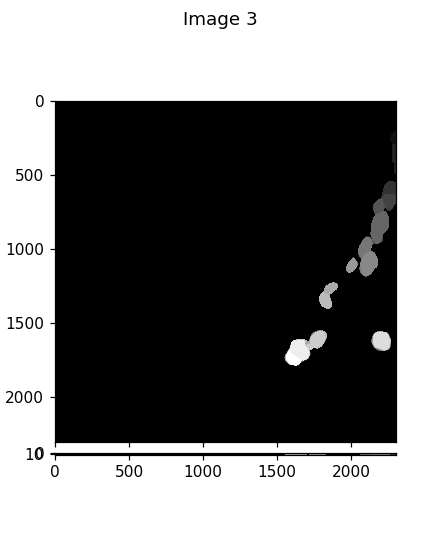

In [21]:
%matplotlib notebook
imshow_mark_3d([_dapi_im, _polyt_im, labels3d])

In [31]:
from merlin.analysis.segment import CellPoseSegment

In [37]:
%%time
combined_labels_3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

CPU times: user 17.9 s, sys: 3.19 s, total: 21.1 s
Wall time: 21.1 s


<IPython.core.display.Javascript object>


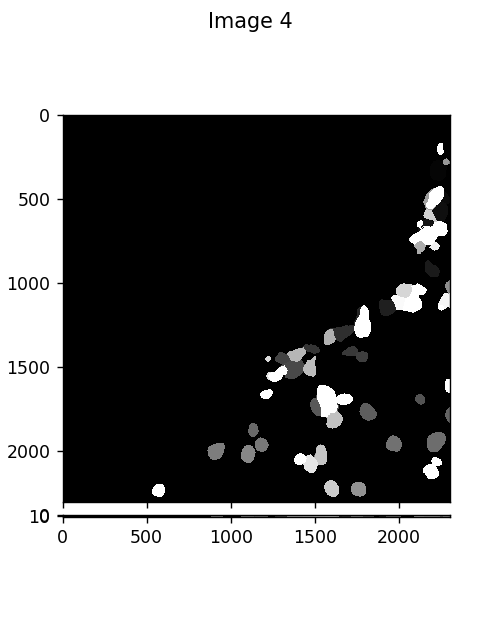

In [38]:
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, combined_labels_3d])

In [ ]:
combined_labels_3d

In [15]:
_ref_cls.correction_log

{'748': {}, '637': {}, '545': {}, '477': {}, '405': {}}

- apply microscope corrections
- run Cellpose segmentation in 179.238s.


In [10]:

for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=60, 
                                        min_size=2000,
                                        do_3D=True,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = labels3d.copy() # no modification is required for this one.

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )

Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_1.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_2.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_3.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_4.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_l

Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_107.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_108.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_109.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_110.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_111.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segm

- apply microscope corrections
- run Cellpose segmentation in 142.370s.
- save to file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_20.npy


<IPython.core.display.Javascript object>


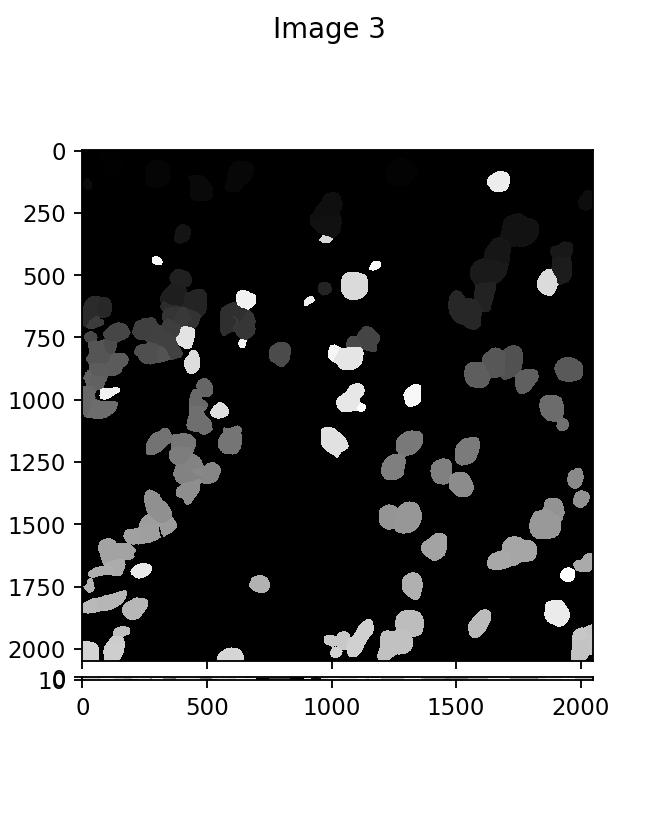

In [24]:
%matplotlib notebook
imshow_mark_3d([polyt_im, dapi_im, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [11]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    #np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    break

- directly load seg from: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy
reference image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H19R1\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
- New save file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488', '405'] in 1.732s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:[

<IPython.core.display.Javascript object>


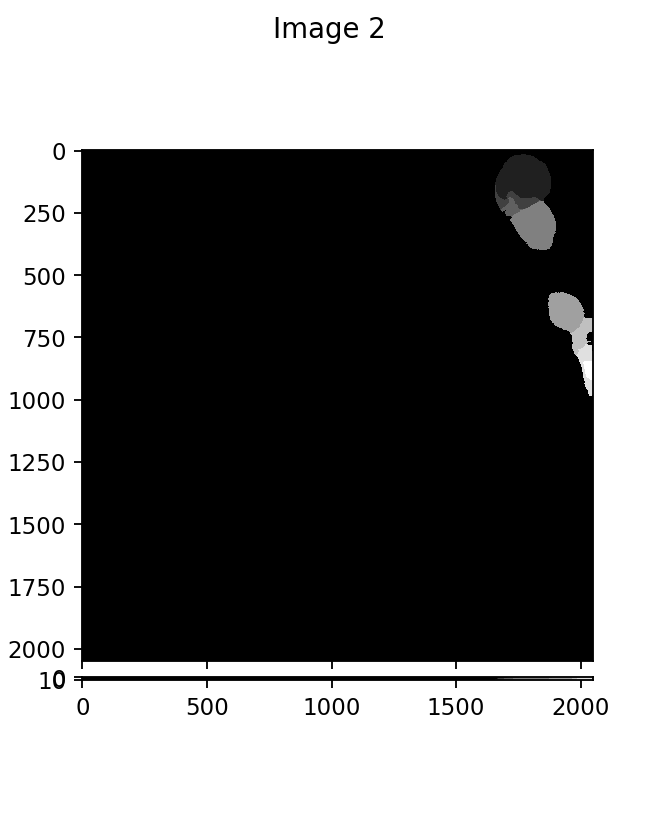

In [203]:
imshow_mark_3d([new_labels, corr_labels3d])

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')